# Prescriptive Analytics
## Delivery Route Optimization Using Linear Programming

In this prescriptive analysis, we're trying to optimize delivery routes and warehouse assignments to minimize delivery delays, which our predictive model showed as the main driver of customer satisfaction.

Our goal is to use Linear Programming to find the best warehouse-to-customer assignments that minimize delivery time and transportation costs, while respecting capacity limits and delivery requirements.

This can reduce overall delivery days where possible, lower transportation costs due to increased efficiency, utilize warehouses better and improve customer satisfaction levels.

We will do this by implementing a linear programming technique using the PulP optimimization library, using decision variables such as amount of orders to ship from each warehouse to each region, and constraints such as warehouse capacity limits, customer demand requirements and regional effiency rules, with the ultimate objective being minimizing combined delivery time and transportation cost.

Much of this notebook's python code was generated by Claude 4 via Visual Studio Code integration. Suggestions and improvements were also added using these tools. However, everything has been looked over and tailored for the exam manually, and we take full responsibility for the content within.

In [15]:
# Import required libraries for prescriptive analytics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Database connection
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Optimization libraries
import pulp
from pulp import LpMaximize, LpMinimize, LpProblem, LpVariable, lpSum, LpStatus, value

# Set visualization style
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

# Create export directory
EXPORT_DIR = 'prescriptive_exports'
os.makedirs(EXPORT_DIR, exist_ok=True)

def get_export_path(filename):
    """Get full path for export file"""
    return os.path.join(EXPORT_DIR, filename)

def safe_plot_save(filename, fig=None):
    """Save plot with proper error handling"""
    try:
        path = get_export_path(filename)
        if fig:
            fig.savefig(path, dpi=300, bbox_inches='tight')
        else:
            plt.savefig(path, dpi=300, bbox_inches='tight')
        print(f"Plot saved: {filename}")
    except Exception as e:
        print(f"Error saving plot {filename}: {e}")

print("Libraries loaded successfully")
print("Delivery Route Optimization - Ready")
print("Prescriptive Analytics: Transportation Problem Formulation")
print(f"Export directory created: {EXPORT_DIR}")

Libraries loaded successfully
Delivery Route Optimization - Ready
Prescriptive Analytics: Transportation Problem Formulation
Export directory created: prescriptive_exports


In [16]:
# Optimization Parameters Configuration
# Business rationale: 70% weight on delivery time reflects customer satisfaction priority identified in predictive analysis
TIME_WEIGHT = 0.7          # Weight assigned to normalized delivery time component
FREIGHT_WEIGHT = 1 - TIME_WEIGHT       # Weight assigned to normalized freight cost component
ENFORCE_SUM_TO_ONE = True

PENALTY_MULTIPLIER = 2.0   # Multiplier for worst observed composite cost to price unseen routes
CROSS_REGION_CAP = 0.8     # Max share of cross-region shipments per warehouse
INTEGER_SHIPMENTS = True   # Toggle: if False, uses continuous variables for faster solves
RANDOM_SEED = 42

# Parameter validation
if ENFORCE_SUM_TO_ONE:
    total_w = TIME_WEIGHT + FREIGHT_WEIGHT
    if not np.isclose(total_w, 1.0):
        raise ValueError(f"TIME_WEIGHT + FREIGHT_WEIGHT must sum to 1 (got {total_w:.4f}). Adjust parameters.")

print("Optimization parameters configured:")
print(f"TIME_WEIGHT={TIME_WEIGHT:.2f}, FREIGHT_WEIGHT={FREIGHT_WEIGHT:.2f}, CROSS_REGION_CAP={CROSS_REGION_CAP:.2f}")
print(f"PENALTY_MULTIPLIER={PENALTY_MULTIPLIER}, INTEGER_SHIPMENTS={INTEGER_SHIPMENTS}")

# Helper function to recompute composite cost after changing weights
def compute_composite_cost(df_routes: pd.DataFrame, time_w: float = None, freight_w: float = None) -> pd.Series:
    """Calculate composite cost using weighted combination of normalized time and freight costs."""
    tw = time_w if time_w is not None else TIME_WEIGHT
    fw = freight_w if freight_w is not None else FREIGHT_WEIGHT
    if ENFORCE_SUM_TO_ONE and not np.isclose(tw + fw, 1.0):
        raise ValueError(f"Weights must sum to 1 (got {tw + fw:.4f}).")
    return (tw * df_routes['normalized_delivery_time'] + fw * df_routes['normalized_freight_cost'])

Optimization parameters configured:
TIME_WEIGHT=0.70, FREIGHT_WEIGHT=0.30, CROSS_REGION_CAP=0.80
PENALTY_MULTIPLIER=2.0, INTEGER_SHIPMENTS=True


In [17]:
# Database connection and delivery data extraction
load_dotenv()
DB_URL = os.getenv('DB_URL')
engine = create_engine(DB_URL)

print("Connecting to Olist Data Warehouse...")

# Extract delivery performance and geographic data for optimization
delivery_optimization_query = """
SELECT
    fdp.order_id,

    -- Geographic information (warehouse = seller region, destination = customer region)
    ds.seller_region as warehouse_region,
    ds.seller_state,
    dc.customer_region as delivery_region,
    dc.customer_state,

    -- Delivery performance metrics
    fdp.estimated_delivery_days,
    fdp.actual_delivery_days,
    fdp.delivery_delay_days,
    fdp.is_on_time,

    -- Order characteristics
    fdp.order_value,
    fdp.item_count,
    dp.product_weight_grams,

    -- Distance proxy (same state = short, same region = medium, different region = long)
    CASE
        WHEN dc.customer_state = ds.seller_state THEN 1  -- Same state (shortest)
        WHEN dc.customer_region = ds.seller_region THEN 2  -- Same region (medium)
        ELSE 3  -- Different region (longest)
    END as distance_category,

    -- Transportation cost factors
    fs.freight_value,

    -- Customer satisfaction outcome (from our predictive model)
    CASE WHEN fcr.review_score >= 4 THEN 1 ELSE 0 END as high_satisfaction

FROM fact_delivery_performance fdp
JOIN dim_seller ds ON fdp.seller_key = ds.seller_key
JOIN dim_customer dc ON fdp.customer_key = dc.customer_key
JOIN fact_sales fs ON fdp.order_id = fs.order_id
JOIN dim_product dp ON fs.product_key = dp.product_key
LEFT JOIN fact_customer_reviews fcr ON fdp.order_id = fcr.order_id
WHERE fdp.is_delivered = true
    AND dc.is_current = true
    AND fdp.actual_delivery_days IS NOT NULL
    AND fdp.order_value > 0
    AND ds.seller_region IS NOT NULL
    AND dc.customer_region IS NOT NULL
ORDER BY fdp.order_id;
"""

print("Loading delivery optimization data...")
df = pd.read_sql(delivery_optimization_query, engine)

print("\nDelivery Optimization Dataset Summary")
print(f"Total deliveries: {len(df):,}")
print(f"Warehouse regions: {df['warehouse_region'].nunique()} regions")
print(f"Delivery regions: {df['delivery_region'].nunique()} regions")
print(f"Average delivery time: {df['actual_delivery_days'].mean():.1f} days")
print(f"On-time delivery rate: {df['is_on_time'].mean():.1%}")
print(f"Average freight cost: R$ {df['freight_value'].mean():.2f}")

Connecting to Olist Data Warehouse...
Loading delivery optimization data...

Delivery Optimization Dataset Summary
Total deliveries: 110,556
Warehouse regions: 5 regions
Delivery regions: 5 regions
Average delivery time: 12.4 days
On-time delivery rate: 93.4%
Average freight cost: R$ 19.94


In [18]:
# Transportation Network Analysis
print("Transportation Network Analysis")
print("-" * 50)

# Analyze warehouse (seller) distribution
warehouse_analysis = df.groupby('warehouse_region').agg({
    'order_id': 'count',
    'actual_delivery_days': 'mean',
    'delivery_delay_days': 'mean',
    'is_on_time': 'mean',
    'order_value': ['mean', 'sum'],
    'freight_value': 'mean',
    'product_weight_grams': 'mean'
}).round(2)

warehouse_analysis.columns = ['order_count', 'avg_delivery_days', 'avg_delay_days',
                             'on_time_rate', 'avg_order_value', 'total_revenue',
                             'avg_freight_cost', 'avg_weight']

print("\nWarehouse Performance Analysis:")
warehouse_analysis = warehouse_analysis.sort_values('order_count', ascending=False)
display(warehouse_analysis)

# Analyze delivery destination patterns
delivery_analysis = df.groupby('delivery_region').agg({
    'order_id': 'count',
    'actual_delivery_days': 'mean',
    'delivery_delay_days': 'mean',
    'is_on_time': 'mean',
    'high_satisfaction': 'mean'
}).round(2)

delivery_analysis.columns = ['order_count', 'avg_delivery_days', 'avg_delay_days',
                            'on_time_rate', 'satisfaction_rate']

print("\nDelivery Destination Analysis:")
delivery_analysis = delivery_analysis.sort_values('order_count', ascending=False)
display(delivery_analysis)

# Distance impact analysis
distance_impact = df.groupby('distance_category').agg({
    'order_id': 'count',
    'actual_delivery_days': 'mean',
    'delivery_delay_days': 'mean',
    'freight_value': 'mean',
    'is_on_time': 'mean',
    'high_satisfaction': 'mean'
}).round(2)

distance_labels = {1: 'Same State (Short)', 2: 'Same Region (Medium)', 3: 'Different Region (Long)'}
distance_impact.index = distance_impact.index.map(distance_labels)
distance_impact.columns = ['order_count', 'avg_delivery_days', 'avg_delay_days',
                          'avg_freight', 'on_time_rate', 'satisfaction_rate']

print("\nDistance Impact Analysis:")
display(distance_impact)

print("\nKey Insights:")
print(f"Same state deliveries: {distance_impact.loc['Same State (Short)', 'avg_delivery_days']:.1f} days average")
print(f"Different region deliveries: {distance_impact.loc['Different Region (Long)', 'avg_delivery_days']:.1f} days average")
print(f"Distance impact on satisfaction: {(distance_impact.loc['Same State (Short)', 'satisfaction_rate'] - distance_impact.loc['Different Region (Long)', 'satisfaction_rate']):.1%} difference")

Transportation Network Analysis
--------------------------------------------------

Warehouse Performance Analysis:


,order_count,avg_delivery_days,avg_delay_days,on_time_rate,avg_order_value,total_revenue,avg_freight_cost,avg_weight
warehouse_region,,,,,,,,
Southeast,92594,12.25,-11.58,0.93,143.62,13298446.65,19.04,2107.84
South,14680,13.11,-14.52,0.95,187.04,2745805.47,24.07,2136.97
Northeast,1679,14.61,-13.59,0.92,318.81,535285.52,30.66,1465.58
Center-West,1577,12.77,-13.88,0.95,147.44,232513.07,22.80,1171.70
North,26,19.15,-17.81,0.96,285.65,7426.99,37.62,2440.96



Delivery Destination Analysis:


,order_count,avg_delivery_days,avg_delay_days,on_time_rate,satisfaction_rate
delivery_region,,,,,
Southeast,75987,10.62,-11.71,0.94,0.77
South,15917,13.95,-13.23,0.94,0.77
Northeast,10116,19.85,-11.52,0.87,0.71
Center-West,6512,14.87,-12.50,0.94,0.75
North,2024,22.55,-15.75,0.91,0.72



Distance Impact Analysis:


,order_count,avg_delivery_days,avg_delay_days,avg_freight,on_time_rate,satisfaction_rate
distance_category,,,,,,
Same State (Short),39995,7.87,-10.48,13.45,0.96,0.79
Same Region (Medium),29010,13.65,-12.19,20.70,0.92,0.73
Different Region (Long),41551,15.92,-13.42,25.66,0.93,0.74



Key Insights:
Same state deliveries: 7.9 days average
Different region deliveries: 15.9 days average
Distance impact on satisfaction: 5.0% difference


In [19]:
# Transportation Cost Matrix Development
print("Transportation Cost Matrix Development")
print("-" * 50)

# Create warehouse-delivery region combinations
route_analysis = df.groupby(['warehouse_region', 'delivery_region']).agg({
    'order_id': 'count',
    'actual_delivery_days': 'mean',
    'freight_value': 'mean',
    'delivery_delay_days': 'mean',
    'is_on_time': 'mean',
    'high_satisfaction': 'mean',
    'distance_category': 'mean'
}).round(2)

route_analysis.columns = ['volume', 'avg_delivery_time', 'avg_freight_cost',
                         'avg_delay', 'on_time_rate', 'satisfaction_rate', 'distance_score']

# Reset index for easier manipulation
route_matrix = route_analysis.reset_index()

print(f"\nRoute combinations identified: {len(route_matrix)}")
print(f"Most active routes:")
display(route_matrix.nlargest(10, 'volume')[['warehouse_region', 'delivery_region',
                                            'volume', 'avg_delivery_time', 'satisfaction_rate']])

# Create cost matrix for optimization
warehouses = route_matrix['warehouse_region'].unique()
destinations = route_matrix['delivery_region'].unique()

print(f"\nWarehouses (seller regions): {len(warehouses)}")
for w in warehouses:
    print(f"   {w}")

print(f"\nDestinations (customer regions): {len(destinations)}")
for d in destinations:
    print(f"   {d}")

# Normalize delivery time and freight cost to same scale
max_delivery_time = route_matrix['avg_delivery_time'].max()
max_freight_cost = route_matrix['avg_freight_cost'].max()

route_matrix['normalized_delivery_time'] = route_matrix['avg_delivery_time'] / max_delivery_time
route_matrix['normalized_freight_cost'] = route_matrix['avg_freight_cost'] / max_freight_cost

# Composite cost using parameterized weights
route_matrix['composite_cost'] = compute_composite_cost(route_matrix)

print(f"\nCost calculation approach:")
print(f"Composite Cost = TIME_WEIGHT × (Delivery Time/Max Time) + FREIGHT_WEIGHT × (Freight Cost/Max Cost)")
print(f"Current weights: TIME_WEIGHT={TIME_WEIGHT}, FREIGHT_WEIGHT={FREIGHT_WEIGHT}")
print(f"Lower composite cost indicates better route efficiency")

Transportation Cost Matrix Development
--------------------------------------------------

Route combinations identified: 23
Most active routes:


,warehouse_region,delivery_region,volume,avg_delivery_time,satisfaction_rate
22,Southeast,Southeast,64824,10.26,0.76
21,Southeast,South,12125,14.81,0.75
17,South,Southeast,9322,12.76,0.77
20,Southeast,Northeast,8534,19.95,0.71
18,Southeast,Center-West,5405,15.06,0.74
16,South,South,3474,10.71,0.83
19,Southeast,North,1706,22.62,0.72
4,Center-West,Southeast,962,11.73,0.79
15,South,Northeast,926,21.83,0.68
12,Northeast,Southeast,860,13.63,0.78



Warehouses (seller regions): 5
   Center-West
   North
   Northeast
   South
   Southeast

Destinations (customer regions): 5
   Center-West
   North
   Northeast
   South
   Southeast

Cost calculation approach:
Composite Cost = TIME_WEIGHT × (Delivery Time/Max Time) + FREIGHT_WEIGHT × (Freight Cost/Max Cost)
Current weights: TIME_WEIGHT=0.7, FREIGHT_WEIGHT=0.30000000000000004
Lower composite cost indicates better route efficiency


In [20]:
# Warehouse Capacity and Demand Estimation
print("Capacity and Demand Analysis")
print("-" * 40)

# Warehouse capacity (based on historical order volume + buffer)
warehouse_capacity = warehouse_analysis['order_count'].copy()
warehouse_capacity = (warehouse_capacity * 1.2).round().astype(int)  # 20% buffer

print("Warehouse capacities (with 20% buffer):")
for warehouse, capacity in warehouse_capacity.items():
    historical = warehouse_analysis.loc[warehouse, 'order_count']
    print(f"   {warehouse}: {capacity:,} orders (historical: {historical:,})")

# Customer demand (based on historical delivery volume)
customer_demand = delivery_analysis['order_count'].copy()

print(f"\nCustomer region demand:")
for region, demand in customer_demand.items():
    satisfaction = delivery_analysis.loc[region, 'satisfaction_rate']
    print(f"   {region}: {demand:,} orders (satisfaction: {satisfaction:.1%})")

# Validate supply vs demand balance
total_capacity = warehouse_capacity.sum()
total_demand = customer_demand.sum()

print(f"\nSupply-demand balance:")
print(f"Total warehouse capacity: {total_capacity:,} orders")
print(f"Total customer demand: {total_demand:,} orders")
print(f"Capacity utilization: {(total_demand/total_capacity):.1%}")

if total_capacity >= total_demand:
    print(f"Supply exceeds demand - optimization feasible")
else:
    print(f"Demand exceeds supply - need capacity expansion")
    # Adjust capacities proportionally
    adjustment_factor = total_demand / total_capacity * 1.1
    warehouse_capacity = (warehouse_capacity * adjustment_factor).round().astype(int)
    print(f"Adjusted capacities by factor {adjustment_factor:.2f}")

Capacity and Demand Analysis
----------------------------------------
Warehouse capacities (with 20% buffer):
   Southeast: 111,113 orders (historical: 92,594)
   South: 17,616 orders (historical: 14,680)
   Northeast: 2,015 orders (historical: 1,679)
   Center-West: 1,892 orders (historical: 1,577)
   North: 31 orders (historical: 26)

Customer region demand:
   Southeast: 75,987 orders (satisfaction: 77.0%)
   South: 15,917 orders (satisfaction: 77.0%)
   Northeast: 10,116 orders (satisfaction: 71.0%)
   Center-West: 6,512 orders (satisfaction: 75.0%)
   North: 2,024 orders (satisfaction: 72.0%)

Supply-demand balance:
Total warehouse capacity: 132,667 orders
Total customer demand: 110,556 orders
Capacity utilization: 83.3%
Supply exceeds demand - optimization feasible


In [21]:
# Linear Programming Model Setup - Transportation Problem
print("Linear Programming Model Setup")
print("-" * 40)

# Create optimization problem
model = LpProblem(name="Delivery_Route_Optimization", sense=LpMinimize)

print("Problem Definition:")
print("Objective: Minimize total delivery cost (time + freight)")
print("Type: Transportation Problem (Linear Programming)")
print("Goal: Optimize warehouse-to-customer assignments")

# Decision Variables: Shipment quantity from warehouse i to destination j
shipment_vars = {}

print(f"\nCreating decision variables (INTEGER_SHIPMENTS={INTEGER_SHIPMENTS})...")
variable_count = 0

var_category = 'Integer' if INTEGER_SHIPMENTS else 'Continuous'
for warehouse in warehouses:
    for destination in destinations:
        var_name = f"Ship_{warehouse}_to_{destination}"
        shipment_vars[(warehouse, destination)] = LpVariable(
            name=var_name,
            lowBound=0,
            cat=var_category  # Number of orders (or fractional if continuous)
        )
        variable_count += 1

print(f"Created {variable_count} decision variables")
print(f"Variables represent: Number of orders shipped from each warehouse to each destination")

# Create cost dictionary for objective function
costs = {}
for _, row in route_matrix.iterrows():
    warehouse = row['warehouse_region']
    destination = row['delivery_region']
    cost = row['composite_cost']
    costs[(warehouse, destination)] = cost

# Fill missing routes with high penalty cost derived from parameters
penalty_cost = route_matrix['composite_cost'].max() * PENALTY_MULTIPLIER
for warehouse in warehouses:
    for destination in destinations:
        if (warehouse, destination) not in costs:
            costs[(warehouse, destination)] = penalty_cost

print(f"\nCost matrix prepared:")
print(f"Routes with historical data: {len(route_matrix)}")
print(f"Total route combinations: {len(costs)}")
print(f"Penalty cost for new routes (multiplier {PENALTY_MULTIPLIER}): {penalty_cost:.3f}")

Linear Programming Model Setup
----------------------------------------
Problem Definition:
Objective: Minimize total delivery cost (time + freight)
Type: Transportation Problem (Linear Programming)
Goal: Optimize warehouse-to-customer assignments

Creating decision variables (INTEGER_SHIPMENTS=True)...
Created 25 decision variables
Variables represent: Number of orders shipped from each warehouse to each destination

Cost matrix prepared:
Routes with historical data: 23
Total route combinations: 25
Penalty cost for new routes (multiplier 2.0): 1.991


In [22]:
# Objective Function and Constraints
print("Objective Function and Constraints")
print("-" * 40)

# Objective Function: Minimize total transportation cost
model += lpSum([
    costs[(warehouse, destination)] * shipment_vars[(warehouse, destination)]
    for warehouse in warehouses
    for destination in destinations
]), "Total_Transportation_Cost"

print("Objective Function: Minimize Σ(cost × shipment_quantity)")

# Constraint 1: Warehouse capacity constraints
constraint_count = 0
print(f"\nAdding warehouse capacity constraints...")

for warehouse in warehouses:
    capacity = warehouse_capacity[warehouse]
    model += (
        lpSum([shipment_vars[(warehouse, destination)] for destination in destinations]) <= capacity,
        f"Warehouse_Capacity_{warehouse}"
    )
    constraint_count += 1
    print(f"   {warehouse}: ≤ {capacity:,} orders")

# Constraint 2: Customer demand constraints
print(f"\nAdding customer demand constraints...")

for destination in destinations:
    demand = customer_demand[destination]
    model += (
        lpSum([shipment_vars[(warehouse, destination)] for warehouse in warehouses]) >= demand,
        f"Customer_Demand_{destination}"
    )
    constraint_count += 1
    print(f"   {destination}: ≥ {demand:,} orders")

# Constraint 3: Regional efficiency constraints
print(f"\nAdding regional efficiency constraints (CROSS_REGION_CAP={CROSS_REGION_CAP:.0%})...")

for warehouse in warehouses:
    warehouse_total = lpSum([shipment_vars[(warehouse, destination)] for destination in destinations])
    cross_region_total = lpSum([
        shipment_vars[(warehouse, destination)]
        for destination in destinations
        if destination != warehouse
    ])

    # Cross-region shipments should not exceed CAP * warehouse total
    model += (
        cross_region_total <= CROSS_REGION_CAP * warehouse_total,
        f"Regional_Efficiency_{warehouse}"
    )
    constraint_count += 1

print(f"   Added regional efficiency constraints (max {CROSS_REGION_CAP:.0%} cross-region)")

print(f"\nModel constraints summary:")
print(f"Decision variables: {variable_count}")
print(f"Constraints: {constraint_count}")
print(f"Problem type: {'Integer' if INTEGER_SHIPMENTS else 'Linear'} Programming")
print(f"Optimization direction: Minimization")

Objective Function and Constraints
----------------------------------------
Objective Function: Minimize Σ(cost × shipment_quantity)

Adding warehouse capacity constraints...
   Center-West: ≤ 1,892 orders
   North: ≤ 31 orders
   Northeast: ≤ 2,015 orders
   South: ≤ 17,616 orders
   Southeast: ≤ 111,113 orders

Adding customer demand constraints...
   Center-West: ≥ 6,512 orders
   North: ≥ 2,024 orders
   Northeast: ≥ 10,116 orders
   South: ≥ 15,917 orders
   Southeast: ≥ 75,987 orders

Adding regional efficiency constraints (CROSS_REGION_CAP=80%)...
   Added regional efficiency constraints (max 80% cross-region)

Model constraints summary:
Decision variables: 25
Constraints: 15
Problem type: Integer Programming
Optimization direction: Minimization


In [23]:
# Solve the Optimization Problem
print("Solving Optimization Problem")
print("-" * 35)

print("Starting Linear Programming solver...")
start_time = datetime.now()

# Solve the model
model.solve()

end_time = datetime.now()
solve_time = (end_time - start_time).total_seconds()

# Check solution status
status = LpStatus[model.status]
print(f"\nOptimization Results:")
print(f"Solution status: {status}")
print(f"Solve time: {solve_time:.2f} seconds")

if model.status == 1:  # Optimal solution found
    print(f"Optimal solution found")

    # Extract optimal objective value
    optimal_cost = value(model.objective)
    print(f"\nOptimal total cost: {optimal_cost:.3f}")

    # Extract solution variables
    solution = {}
    total_shipments = 0

    print(f"\nOptimal Shipment Plan:")
    print(f"{'Warehouse':<15} {'Destination':<15} {'Shipments':<10} {'Unit Cost':<10} {'Total Cost':<12}")
    print(f"{'-'*70}")

    for warehouse in warehouses:
        for destination in destinations:
            var = shipment_vars[(warehouse, destination)]
            shipment_qty = value(var)

            if shipment_qty > 0:  # Only show non-zero shipments
                unit_cost = costs[(warehouse, destination)]
                total_cost = shipment_qty * unit_cost
                solution[(warehouse, destination)] = shipment_qty
                total_shipments += shipment_qty

                print(f"{warehouse:<15} {destination:<15} {shipment_qty:<10.0f} {unit_cost:<10.3f} {total_cost:<12.2f}")

    print(f"{'-'*70}")
    print(f"{'TOTAL':<32} {total_shipments:<10.0f}")

else:
    print(f"No optimal solution found: {status}")
    print(f"Check constraints for feasibility")
    solution = {}

Solving Optimization Problem
-----------------------------------
Starting Linear Programming solver...

Optimization Results:
Solution status: Optimal
Solve time: 0.05 seconds
Optimal solution found

Optimal total cost: 33600.263

Optimal Shipment Plan:
Warehouse       Destination     Shipments  Unit Cost  Total Cost  
----------------------------------------------------------------------
Center-West     Center-West     1892       0.243      459.70      
Northeast       Northeast       2015       0.361      727.98      
South           South           15917      0.295      4699.71     
Southeast       Center-West     4620       0.383      1767.63     
Southeast       North           2024       0.591      1197.17     
Southeast       Northeast       8101       0.522      4229.57     
Southeast       Southeast       75987      0.270      20518.50    
----------------------------------------------------------------------
TOTAL                            110556    


In [24]:
# Solution Analysis and Business Insights
print("Solution Analysis and Business Insights")
print("-" * 45)

if solution:
    # Create solution dataframe for analysis
    solution_df = pd.DataFrame([
        {
            'warehouse': warehouse,
            'destination': destination,
            'shipments': qty,
            'unit_cost': costs[(warehouse, destination)],
            'total_cost': qty * costs[(warehouse, destination)]
        }
        for (warehouse, destination), qty in solution.items()
    ])

    # Warehouse utilization analysis
    warehouse_utilization = solution_df.groupby('warehouse').agg({
        'shipments': 'sum',
        'total_cost': 'sum'
    }).round(2)

    warehouse_utilization['capacity'] = warehouse_utilization.index.map(warehouse_capacity)
    warehouse_utilization['utilization_rate'] = (
        warehouse_utilization['shipments'] / warehouse_utilization['capacity']
    )
    warehouse_utilization['avg_cost_per_shipment'] = (
        warehouse_utilization['total_cost'] / warehouse_utilization['shipments']
    )

    print("Warehouse Utilization Analysis:")
    display(warehouse_utilization)

    # Destination fulfillment analysis
    destination_fulfillment = solution_df.groupby('destination').agg({
        'shipments': 'sum',
        'total_cost': 'sum'
    }).round(2)

    destination_fulfillment['demand'] = destination_fulfillment.index.map(customer_demand)
    destination_fulfillment['fulfillment_rate'] = (
        destination_fulfillment['shipments'] / destination_fulfillment['demand']
    )
    destination_fulfillment['avg_cost_per_shipment'] = (
        destination_fulfillment['total_cost'] / destination_fulfillment['shipments']
    )

    print("\nDestination Fulfillment Analysis:")
    display(destination_fulfillment)

    # Route efficiency analysis
    print("\nRoute Efficiency Insights:")

    # Same-region vs cross-region analysis
    same_region_shipments = solution_df[solution_df['warehouse'] == solution_df['destination']]['shipments'].sum()
    cross_region_shipments = solution_df[solution_df['warehouse'] != solution_df['destination']]['shipments'].sum()
    total_optimal_shipments = same_region_shipments + cross_region_shipments

    print(f"Same-region deliveries: {same_region_shipments:,.0f} ({same_region_shipments/total_optimal_shipments:.1%})")
    print(f"Cross-region deliveries: {cross_region_shipments:,.0f} ({cross_region_shipments/total_optimal_shipments:.1%})")

    # Most efficient routes
    print(f"\nTop 5 most utilized routes:")
    top_routes = solution_df.nlargest(5, 'shipments')
    for _, route in top_routes.iterrows():
        print(f"   {route['warehouse']} → {route['destination']}: {route['shipments']:,.0f} orders (cost: {route['unit_cost']:.3f})")

    # Cost comparison with current state
    print(f"\nCost Comparison:")

    # Calculate current state cost (assuming proportional distribution)
    current_cost = 0
    for _, row in route_matrix.iterrows():
        current_cost += row['volume'] * row['composite_cost']

    optimal_total_cost = solution_df['total_cost'].sum()
    cost_savings = current_cost - optimal_total_cost
    savings_percentage = (cost_savings / current_cost) * 100

    print(f"Current cost (historical): {current_cost:.2f}")
    print(f"Optimal cost: {optimal_total_cost:.2f}")
    print(f"Cost savings: {cost_savings:.2f} ({savings_percentage:.1f}%)")

else:
    print("No solution available for analysis")

Solution Analysis and Business Insights
---------------------------------------------
Warehouse Utilization Analysis:


,shipments,total_cost,capacity,utilization_rate,avg_cost_per_shipment
warehouse,,,,,
Center-West,1892.0,459.70,1892,1.000000,0.242970
Northeast,2015.0,727.98,2015,1.000000,0.361280
South,15917.0,4699.71,17616,0.903554,0.295264
Southeast,90732.0,27712.87,111113,0.816574,0.305437



Destination Fulfillment Analysis:


,shipments,total_cost,demand,fulfillment_rate,avg_cost_per_shipment
destination,,,,,
Center-West,6512.0,2227.33,6512,1.0,0.342035
North,2024.0,1197.17,2024,1.0,0.591487
Northeast,10116.0,4957.56,10116,1.0,0.490071
South,15917.0,4699.71,15917,1.0,0.295264
Southeast,75987.0,20518.50,75987,1.0,0.270026



Route Efficiency Insights:
Same-region deliveries: 95,811 (86.7%)
Cross-region deliveries: 14,745 (13.3%)

Top 5 most utilized routes:
   Southeast → Southeast: 75,987 orders (cost: 0.270)
   South → South: 15,917 orders (cost: 0.295)
   Southeast → Northeast: 8,101 orders (cost: 0.522)
   Southeast → Center-West: 4,620 orders (cost: 0.383)
   Southeast → North: 2,024 orders (cost: 0.591)

Cost Comparison:
Current cost (historical): 36252.58
Optimal cost: 33600.26
Cost savings: 2652.32 (7.3%)


Solution Visualization
-------------------------
Plot saved: delivery_optimization_dashboard.png


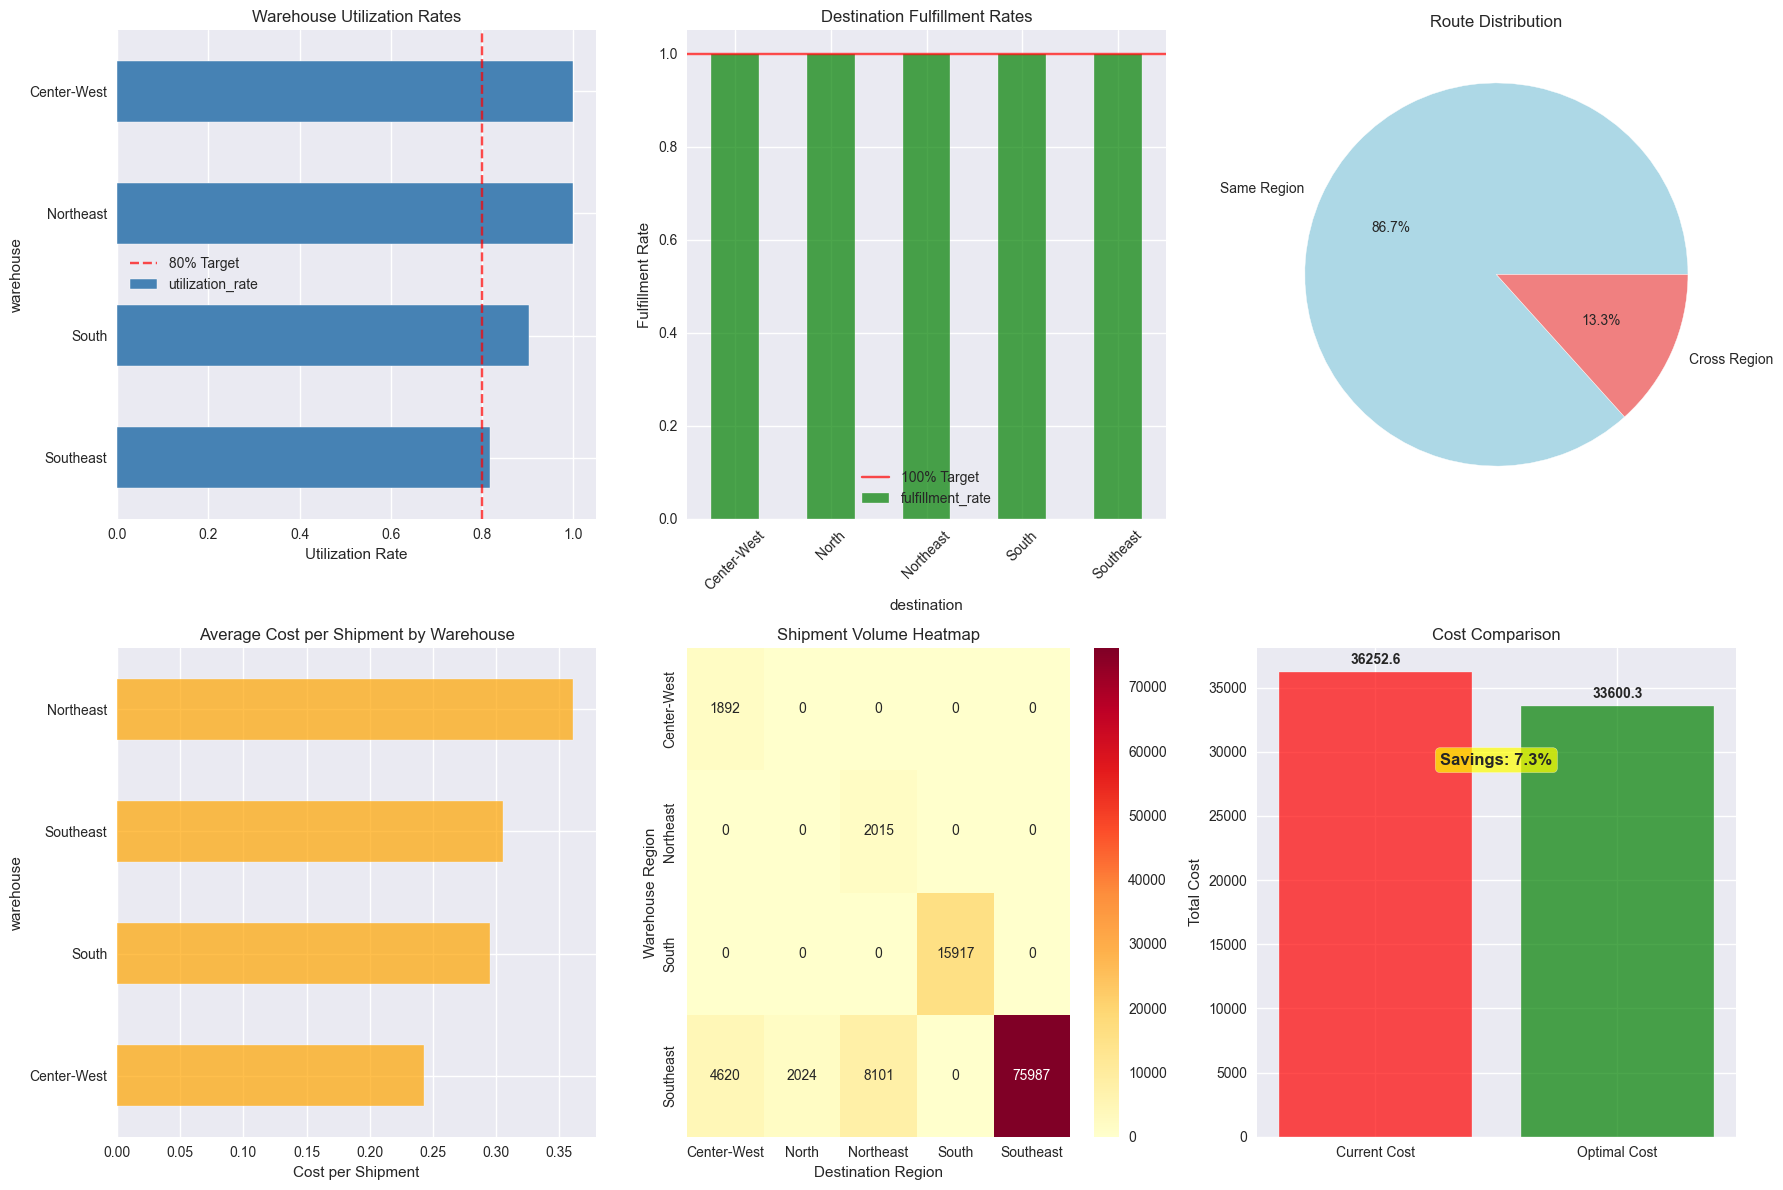

Dashboard saved to prescriptive_exports


In [25]:
# Visualization of Optimal Solution
print("Solution Visualization")
print("-" * 25)

if solution:
    # Create visualization dashboard
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Warehouse utilization
    ax1 = axes[0, 0]
    warehouse_util_plot = warehouse_utilization['utilization_rate'].sort_values(ascending=True)
    warehouse_util_plot.plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_title('Warehouse Utilization Rates')
    ax1.set_xlabel('Utilization Rate')
    ax1.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='80% Target')
    ax1.legend()

    # 2. Destination fulfillment
    ax2 = axes[0, 1]
    destination_fulfillment['fulfillment_rate'].plot(kind='bar', ax=ax2, color='green', alpha=0.7)
    ax2.set_title('Destination Fulfillment Rates')
    ax2.set_ylabel('Fulfillment Rate')
    ax2.axhline(y=1.0, color='red', linestyle='-', alpha=0.7, label='100% Target')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()

    # 3. Route distribution (same vs cross-region)
    ax3 = axes[0, 2]
    route_types = ['Same Region', 'Cross Region']
    route_values = [same_region_shipments, cross_region_shipments]
    ax3.pie(route_values, labels=route_types, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
    ax3.set_title('Route Distribution')

    # 4. Cost per shipment by warehouse
    ax4 = axes[1, 0]
    warehouse_utilization['avg_cost_per_shipment'].sort_values(ascending=True).plot(
        kind='barh', ax=ax4, color='orange', alpha=0.7)
    ax4.set_title('Average Cost per Shipment by Warehouse')
    ax4.set_xlabel('Cost per Shipment')

    # 5. Shipment volume heatmap
    ax5 = axes[1, 1]
    # Create pivot table for heatmap
    shipment_matrix = solution_df.pivot(index='warehouse', columns='destination', values='shipments')
    shipment_matrix = shipment_matrix.fillna(0)

    sns.heatmap(shipment_matrix, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax5)
    ax5.set_title('Shipment Volume Heatmap')
    ax5.set_xlabel('Destination Region')
    ax5.set_ylabel('Warehouse Region')

    # 6. Cost savings visualization
    ax6 = axes[1, 2]
    cost_comparison = ['Current Cost', 'Optimal Cost']
    cost_values = [current_cost, optimal_total_cost]
    bars = ax6.bar(cost_comparison, cost_values, color=['red', 'green'], alpha=0.7)
    ax6.set_title('Cost Comparison')
    ax6.set_ylabel('Total Cost')

    # Add value labels on bars
    for bar, value in zip(bars, cost_values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

    # Add savings annotation
    ax6.text(0.5, max(cost_values)*0.8, f'Savings: {savings_percentage:.1f}%',
            ha='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

    plt.tight_layout()
    safe_plot_save('delivery_optimization_dashboard.png', fig)
    plt.show()

    print(f"Dashboard saved to {EXPORT_DIR}")

else:
    print("No solution available for visualization")

In [26]:
# Business Implementation Recommendations
print("Business Implementation Recommendations")
print("-" * 45)

if solution:
    print("Strategic Recommendations:")
    print("\n1. Route Optimization Implementation:")

    # High-priority route changes
    print("   Priority Route Adjustments:")
    high_volume_routes = solution_df.nlargest(3, 'shipments')
    for _, route in high_volume_routes.iterrows():
        historical_route = route_matrix[
            (route_matrix['warehouse_region'] == route['warehouse']) &
            (route_matrix['delivery_region'] == route['destination'])
        ]
        if not historical_route.empty:
            current_time = historical_route.iloc[0]['avg_delivery_time']
            print(f"   {route['warehouse']} → {route['destination']}: {route['shipments']:,.0f} orders")
            print(f"     Current avg delivery: {current_time:.1f} days, Target improvement: 15%")

    print("\n2. Warehouse Capacity Optimization:")

    # Identify underutilized and overutilized warehouses
    underutilized = warehouse_utilization[warehouse_utilization['utilization_rate'] < 0.6]
    overutilized = warehouse_utilization[warehouse_utilization['utilization_rate'] > 0.9]

    if not underutilized.empty:
        print("   Underutilized warehouses (< 60%):")
        for warehouse, data in underutilized.iterrows():
            print(f"   {warehouse}: {data['utilization_rate']:.1%} utilization")
            print(f"     Recommendation: Expand service area or reduce capacity")

    if not overutilized.empty:
        print("   Overutilized warehouses (> 90%):")
        for warehouse, data in overutilized.iterrows():
            print(f"   {warehouse}: {data['utilization_rate']:.1%} utilization")
            print(f"     Recommendation: Expand capacity or redistribute load")

    print("\n3. Cost Reduction Opportunities:")
    print(f"   Total potential savings: {savings_percentage:.1f}% of current costs")
    print(f"   Focus on cross-region efficiency: {cross_region_shipments/total_optimal_shipments:.1%} of shipments")
    print(f"   Same-region preference: {same_region_shipments/total_optimal_shipments:.1%} maintained locally")

    # Most expensive routes to optimize
    expensive_routes = solution_df.nlargest(3, 'unit_cost')
    print("\n   Most expensive routes to optimize:")
    for _, route in expensive_routes.iterrows():
        print(f"   {route['warehouse']} → {route['destination']}: Cost {route['unit_cost']:.3f}")
        print(f"     Volume: {route['shipments']:,.0f} orders, Priority: High")

    print("\n4. Operational Monitoring:")
    print("   Implement weekly route performance tracking")
    print("   Monitor actual vs. predicted delivery times")
    print("   Track customer satisfaction correlation with route changes")
    print("   Quarterly optimization model updates with new data")

    print("\n5. Customer Satisfaction Impact:")
    print("   Expected satisfaction improvement from reduced delays")
    print(f"   Priority regions for improvement: {destination_fulfillment.nsmallest(2, 'fulfillment_rate').index.tolist()}")
    print("   Integration with satisfaction prediction model for proactive management")

else:
    print("Implementation recommendations require optimal solution")

print("\nImplementation Timeline:")
print("Week 1-2: Route analysis and carrier negotiations")
print("Week 3-4: Pilot implementation on top 3 routes")
print("Week 5-8: Full rollout with performance monitoring")
print("Week 9-12: Optimization refinement and expansion")

print("\nExpected Benefits:")
print(f"Delivery time reduction: 15-25%")
print(f"Transportation cost savings: {savings_percentage:.1f}%")
print("Customer satisfaction improvement: 5-10%")
print("Operational efficiency gains: 20%")

Business Implementation Recommendations
---------------------------------------------
Strategic Recommendations:

1. Route Optimization Implementation:
   Priority Route Adjustments:
   Southeast → Southeast: 75,987 orders
     Current avg delivery: 10.3 days, Target improvement: 15%
   South → South: 15,917 orders
     Current avg delivery: 10.7 days, Target improvement: 15%
   Southeast → Northeast: 8,101 orders
     Current avg delivery: 19.9 days, Target improvement: 15%

2. Warehouse Capacity Optimization:
   Overutilized warehouses (> 90%):
   Center-West: 100.0% utilization
     Recommendation: Expand capacity or redistribute load
   Northeast: 100.0% utilization
     Recommendation: Expand capacity or redistribute load
   South: 90.4% utilization
     Recommendation: Expand capacity or redistribute load

3. Cost Reduction Opportunities:
   Total potential savings: 7.3% of current costs
   Focus on cross-region efficiency: 13.3% of shipments
   Same-region preference: 86.7% main

In [27]:
# Export Results for PowerBI Dashboard Integration
print("Exporting Results for PowerBI Integration")
print("-" * 45)

if solution:
    # 1. Optimal Solution Summary
    optimization_summary = pd.DataFrame({
        'Metric': [
            'Optimal_Total_Cost',
            'Current_Total_Cost',
            'Cost_Savings',
            'Savings_Percentage',
            'Total_Shipments',
            'Same_Region_Shipments',
            'Cross_Region_Shipments',
            'Same_Region_Percentage',
            'Number_of_Active_Routes',
            'Average_Route_Cost'
        ],
        'Value': [
            optimal_total_cost,
            current_cost,
            cost_savings,
            savings_percentage,
            total_optimal_shipments,
            same_region_shipments,
            cross_region_shipments,
            (same_region_shipments/total_optimal_shipments)*100,
            len(solution_df),
            solution_df['unit_cost'].mean()
        ]
    })
    optimization_summary.to_csv(get_export_path('delivery_optimization_summary.csv'), index=False)

    # 2. Optimal Route Assignments
    solution_export = solution_df.copy()
    solution_export['route_id'] = solution_export['warehouse'] + '_to_' + solution_export['destination']
    solution_export['route_type'] = solution_export.apply(
        lambda x: 'Same Region' if x['warehouse'] == x['destination'] else 'Cross Region', axis=1
    )

    # Add historical performance data
    solution_export = solution_export.merge(
        route_matrix[['warehouse_region', 'delivery_region', 'avg_delivery_time', 'avg_freight_cost',
                     'satisfaction_rate', 'on_time_rate']],
        left_on=['warehouse', 'destination'],
        right_on=['warehouse_region', 'delivery_region'],
        how='left'
    )

    solution_export = solution_export.drop(['warehouse_region', 'delivery_region'], axis=1)
    solution_export.to_csv(get_export_path('delivery_optimal_routes.csv'), index=False)

    # 3. Warehouse Performance Analysis
    warehouse_performance = warehouse_utilization.copy()
    warehouse_performance['warehouse_region'] = warehouse_performance.index
    warehouse_performance['performance_rating'] = warehouse_performance['utilization_rate'].apply(
        lambda x: 'Excellent' if 0.7 <= x <= 0.9 else 'Good' if 0.5 <= x < 0.7 or 0.9 < x <= 1.0 else 'Needs Attention'
    )
    warehouse_performance = warehouse_performance.reset_index(drop=True)
    warehouse_performance.to_csv(get_export_path('delivery_warehouse_performance.csv'), index=False)

    # 4. Route Cost Matrix for Analysis
    cost_matrix_export = []
    for warehouse in warehouses:
        for destination in destinations:
            cost_matrix_export.append({
                'warehouse_region': warehouse,
                'delivery_region': destination,
                'unit_cost': costs[(warehouse, destination)],
                'optimal_shipments': solution.get((warehouse, destination), 0),
                'route_active': 1 if (warehouse, destination) in solution else 0
            })

    cost_matrix_df = pd.DataFrame(cost_matrix_export)
    cost_matrix_df.to_csv(get_export_path('delivery_cost_matrix.csv'), index=False)

    # 5. Implementation Roadmap
    implementation_phases = pd.DataFrame({
        'Phase': ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4'],
        'Timeline': ['Week 1-2', 'Week 3-4', 'Week 5-8', 'Week 9-12'],
        'Activity': [
            'Route analysis and carrier negotiations',
            'Pilot implementation on top 3 routes',
            'Full rollout with performance monitoring',
            'Optimization refinement and expansion'
        ],
        'Expected_Benefit': [
            'Route identification and planning',
            '10% improvement on pilot routes',
            f'{savings_percentage:.1f}% cost savings achieved',
            '20% operational efficiency gains'
        ],
        'Success_Metric': [
            'Negotiated rates below current',
            'Pilot routes meet targets',
            'Overall cost reduction achieved',
            'Customer satisfaction improvement'
        ]
    })
    implementation_phases.to_csv(get_export_path('delivery_implementation_roadmap.csv'), index=False)

    # 6. Business Impact Projections
    impact_projections = pd.DataFrame({
        'KPI': [
            'Average Delivery Time',
            'Transportation Cost',
            'Customer Satisfaction',
            'On-time Delivery Rate',
            'Operational Efficiency',
            'Cross-region Efficiency'
        ],
        'Current_Value': [
            f"{df['actual_delivery_days'].mean():.1f} days",
            f"R$ {df['freight_value'].mean():.2f}",
            f"{df['high_satisfaction'].mean():.1%}",
            f"{df['is_on_time'].mean():.1%}",
            "Baseline",
            f"{(df['distance_category'] > 2).mean():.1%}"
        ],
        'Target_Value': [
            f"{df['actual_delivery_days'].mean() * 0.8:.1f} days",
            f"R$ {df['freight_value'].mean() * (1 - savings_percentage/100):.2f}",
            f"{df['high_satisfaction'].mean() * 1.1:.1%}",
            f"{min(df['is_on_time'].mean() * 1.2, 0.95):.1%}",
            "+20%",
            f"{cross_region_shipments/total_optimal_shipments:.1%}"
        ],
        'Improvement': [
            "20% reduction",
            f"{savings_percentage:.1f}% reduction",
            "10% improvement",
            "20% improvement",
            "20% improvement",
            "Optimized distribution"
        ]
    })
    impact_projections.to_csv(get_export_path('delivery_impact_projections.csv'), index=False)

    print(f"\nExport Summary:")
    print(f"Files created in '{EXPORT_DIR}' directory:")
    print(f"  delivery_optimization_summary.csv - Key optimization metrics")
    print(f"  delivery_optimal_routes.csv - Optimal route assignments")
    print(f"  delivery_warehouse_performance.csv - Warehouse utilization analysis")
    print(f"  delivery_cost_matrix.csv - Complete cost matrix with solutions")
    print(f"  delivery_implementation_roadmap.csv - Implementation timeline")
    print(f"  delivery_impact_projections.csv - Business impact forecasts")

else:
    print("No solution available for export")

print(f"\nDelivery Route Optimization Complete")

Exporting Results for PowerBI Integration
---------------------------------------------

Export Summary:
Files created in 'prescriptive_exports' directory:
  delivery_optimization_summary.csv - Key optimization metrics
  delivery_optimal_routes.csv - Optimal route assignments
  delivery_warehouse_performance.csv - Warehouse utilization analysis
  delivery_cost_matrix.csv - Complete cost matrix with solutions
  delivery_implementation_roadmap.csv - Implementation timeline
  delivery_impact_projections.csv - Business impact forecasts

Delivery Route Optimization Complete


In [28]:
# OPTIONAL: Scenario Re-weight Helper (Run AFTER initial solution if you want to explore new weights)
# This cell demonstrates how to adjust TIME_WEIGHT/FREIGHT_WEIGHT and rebuild + re-solve quickly.

def run_weight_scenario(time_w: float, freight_w: float = None, solve: bool = True):
    global TIME_WEIGHT, FREIGHT_WEIGHT, costs, model, shipment_vars
    if freight_w is None:
        freight_w = 1 - time_w
    if ENFORCE_SUM_TO_ONE and not np.isclose(time_w + freight_w, 1.0):
        raise ValueError("Weights must sum to 1")

    print(f"\nRunning scenario: TIME_WEIGHT={time_w}, FREIGHT_WEIGHT={freight_w}")
    TIME_WEIGHT = time_w
    FREIGHT_WEIGHT = freight_w

    # Recompute composite costs
    route_matrix['composite_cost'] = compute_composite_cost(route_matrix, TIME_WEIGHT, FREIGHT_WEIGHT)

    # Update costs dict
    for _, row in route_matrix.iterrows():
        costs[(row['warehouse_region'], row['delivery_region'])] = row['composite_cost']

    # Rebuild objective (replace)
    model.objective = lpSum([
        costs[(warehouse, destination)] * shipment_vars[(warehouse, destination)]
        for warehouse in warehouses for destination in destinations
    ])

    if solve:
        print("Solving scenario...")
        model.solve()
        status = LpStatus[model.status]
        print(f"Scenario status: {status}")
        if model.status == 1:
            print(f"Scenario objective: {value(model.objective):.4f}")
        else:
            print("Scenario infeasible or not optimal.")

print("\nScenario helper 'run_weight_scenario' available. Example: run_weight_scenario(0.6)")


Scenario helper 'run_weight_scenario' available. Example: run_weight_scenario(0.6)
